In [ ]:
# | default_exp model.nbeats

In [ ]:
# | export
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchmetrics import SymmetricMeanAbsolutePercentageError

from ts.commons.loss import MASE, OWA

In [ ]:
# | export
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

--------------

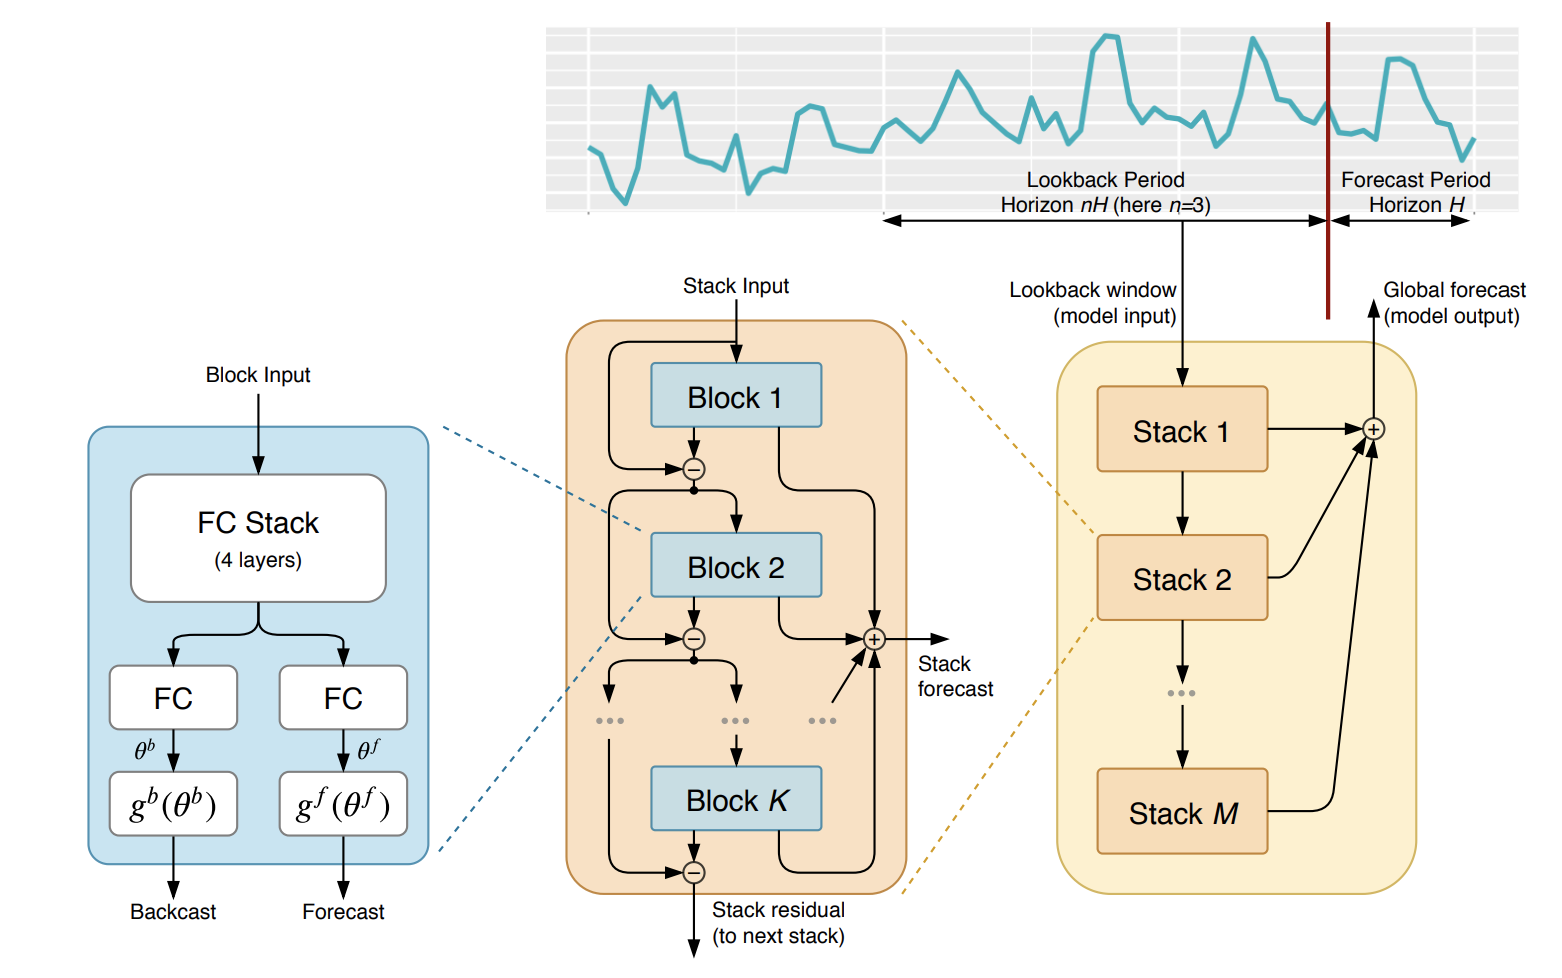

## "N-BEATS: Neural Basis Expansion Analysis for Interpretable Time Series Forecasting"

---

### **Overview and Motivation**
The paper focuses on solving the **univariate time series point forecasting problem**—predicting future values of a single variable based on its historical data—using a pure deep learning approach. Traditionally, time series forecasting has relied heavily on statistical methods (e.g., ARIMA, exponential smoothing) or hybrid models combining statistical techniques with machine learning (e.g., the M4 competition winner, which blended neural networks with Holt-Winters). These methods often require domain-specific tuning or feature engineering, and their interpretability can vary.

The authors challenge the prevailing view (e.g., from Makridakis et al., 2018) that hybrid models are the best path forward for forecasting accuracy. Instead, they propose **N-BEATS** (Neural Basis Expansion Analysis for Time Series), a deep neural network architecture that:
1. Outperforms statistical and hybrid benchmarks using pure deep learning.
2. Offers interpretability without sacrificing accuracy.
3. Works across diverse domains without modification.

Their motivation stems from two hypotheses:
- **Hypothesis 1**: Deep learning alone, without time-series-specific components, can effectively solve forecasting problems.
- **Hypothesis 2**: A deep learning model can be designed with an inductive bias to produce interpretable outputs (e.g., trend and seasonality components) while maintaining high accuracy.

---

### **Key Concepts**
N-BEATS is built around the idea of **basis expansion**, a technique where a time series is decomposed into a set of basis functions (like polynomials or sines/cosines) whose coefficients are learned by a neural network. This allows the model to capture patterns such as trends and seasonality in an interpretable way, while its deep architecture ensures flexibility and predictive power.

The architecture uses:
- **Residual connections**: Inspired by ResNet (used in image recognition), these allow the network to learn incrementally by passing information forward and backward.
- **Double residual stacking**: A unique design that separates forecasting (predicting future values) from backcasting (reconstructing past values), enhancing both accuracy and interpretability.
- **Modularity**: The model is composed of reusable blocks and stacks, making it extensible and adaptable.

---

### **Architecture**
The N-BEATS architecture is hierarchical and consists of **blocks** organized into **stacks**. Here's a detailed breakdown:

#### **Basic Building Block**
- Each block is a **multi-layer fully-connected (FC) neural network** with ReLU activations.
- It takes an input time series segment (called the **lookback window**) and produces two outputs:
  1. **Forecast**: Predicted future values (denoted as \(\hat{y}\)).
  2. **Backcast**: Reconstructed past values (denoted as \(\hat{x}\)).
- The block learns **expansion coefficients** (\(\theta^f\) for forecast, \(\theta^b\) for backcast) via its FC layers.
- These coefficients are then projected onto **basis functions** (\(g^f\) for forecast, \(g^b\) for backcast) to generate the final outputs:
  \[
  \hat{y}_\ell = V^f_\ell \theta^f_\ell, \quad \hat{x}_\ell = V^b_\ell \theta^b_\ell
  \]
  where \(V^f\) and \(V^b\) are basis vectors (either learned or predefined).

#### **Doubly Residual Stacking**
- Blocks are grouped into **stacks**, and stacks are connected in a chain.
- Each block subtracts its backcast (\(\hat{x}_\ell\)) from the input to produce a residual, which is passed to the next block:
  \[
  x_{\ell+1} = x_\ell - \hat{x}_\ell
  \]
- Forecasts from each block (\(\hat{y}_\ell\)) are summed hierarchically across the stack to produce the final prediction:
  \[
  \hat{y} = \sum_{\ell} \hat{y}_\ell
  \]
- This "double residual" approach (residuals in both backward and forward directions) mimics how ResNet refines predictions layer by layer, but it’s tailored for time series.

#### **Two Configurations**
The paper proposes two variants of N-BEATS:
1. **Generic (N-BEATS-G)**:
   - Uses generic, learnable basis functions (no predefined structure).
   - Relies purely on deep learning primitives (e.g., residual blocks) without time-series-specific assumptions.
   - Comprises many stacks (e.g., 30) with multiple blocks each, making it highly flexible but less interpretable.
2. **Interpretable (N-BEATS-I)**:
   - Incorporates predefined basis functions with an inductive bias:
     - **Trend stack**: Uses polynomial basis functions (e.g., \(t, t^2, \ldots, t^p\)) to model smooth, monotonic trends.
     - **Seasonality stack**: Uses Fourier-like basis functions (sines and cosines) to capture periodic patterns.
   - Typically uses just two stacks (trend + seasonality), making outputs directly interpretable as trend and seasonal components.
   - Shares basis layer weights within each stack for consistency.

#### **Hyperparameters**
- **Lookback window**: Typically 2–7 times the forecast horizon (H), allowing the model to see sufficient history.
- **Depth**: N-BEATS-G uses a deep stack (e.g., 30 stacks, 3 blocks each), while N-BEATS-I is shallower (2 stacks).
- **Width**: Each FC layer has 512 units, creating a "very deep" network.

---

### **Training and Evaluation**
- **Loss Function**: Mean squared error (MSE) between the predicted forecast (\(\hat{y}\)) and true future values (y).
- **Datasets**: Tested on well-known benchmarks:
  - **M4**: 100,000 time series from diverse domains (e.g., finance, industry), with horizons of 6–48 steps.
  - **M3**: Smaller dataset with similar diversity.
  - **TOURISM**: Tourism-related time series.
- **Metrics**:
  - **SMAPE** (Symmetric Mean Absolute Percentage Error).
  - **MASE** (Mean Absolute Scaled Error).
  - **OWA** (Overall Weighted Average, combining SMAPE and MASE relative to a naïve baseline).
- **Ensembling**: To maximize performance, the authors ensemble multiple N-BEATS models with different lookback windows (2H to 7H) and random initializations.

---

### **Key Results**
1. **Performance**:
   - **N-BEATS-G**: Outperforms the M4 winner (a hybrid neural-statistical model) by 3% in OWA, and statistical benchmarks by 11%.
   - **N-BEATS-I**: Slightly less accurate than N-BEATS-G but still competitive, with the added benefit of interpretability.
   - The ensemble (N-BEATS-I+G) achieves the best results across all datasets (M3, M4, TOURISM).
2. **Generalization**:
   - N-BEATS-G’s success without time-series-specific components supports Hypothesis 1: deep learning primitives (e.g., residual blocks) are sufficient for forecasting across domains.
3. **Interpretability**:
   - N-BEATS-I decomposes forecasts into trend and seasonality, aligning with classical time series analysis (e.g., STL decomposition), validating Hypothesis 2.

---

### **Contributions**
1. **Pure Deep Learning Breakthrough**:
   - First work to show that a pure deep learning model can outperform statistical and hybrid approaches on large-scale univariate forecasting tasks.
2. **Interpretability**:
   - Offers a way to inject inductive bias (trend/seasonality) into a neural network, making outputs actionable for practitioners.
3. **Simplicity and Flexibility**:
   - Requires no feature engineering or domain-specific tuning, unlike many traditional methods.
   - Fast to train due to its fully-connected structure (no recurrent or convolutional layers).
4. **Proof of Concept**:
   - Challenges the notion that hybrid models are inherently superior, opening the door for further deep learning research in time series.

---

### **Significance and Implications**
- **Challenging the Status Quo**: The paper refutes claims that deep learning alone cannot compete with statistical methods, providing a "long-missing proof of concept" for pure ML in forecasting.
- **Practical Use**: N-BEATS-I’s interpretable outputs (trend + seasonality) make it valuable for business applications like inventory management or financial planning, where understanding the "why" behind predictions matters.
- **Research Direction**: Encourages exploration of deep learning architectures for time series, potentially reducing reliance on hybrid or statistical methods.

---

### **Limitations and Future Work**
- **Univariate Focus**: N-BEATS is designed for univariate time series, not multivariate ones (though later work, e.g., N-BEATSx, extends it to exogenous variables).
- **Ensembling Dependency**: Top performance relies on ensembling, which increases computational cost.
- **Interpretability Trade-off**: N-BEATS-G is more accurate but less interpretable, while N-BEATS-I sacrifices some accuracy for clarity.
- Future directions could include adapting N-BEATS for multivariate forecasting, optimizing it for real-time use, or exploring transfer learning across datasets.

---



## Ablation Study

### **1. Effect of Architecture Depth (Number of Stacks and Blocks)**
- **Objective**: Test how the depth of the network (i.e., the number of stacks and blocks per stack) affects performance.
- **Changes**:
  - **Baseline**: The default N-BEATS-G configuration uses 30 stacks, each with 3 blocks (90 blocks total).
  - **Ablated Variants**:
    - Reduced to **1 stack with 1 block** (shallowest configuration).
    - Reduced to **10 stacks with 3 blocks** (moderate depth, 30 blocks total).
    - Compared against the full 30-stack, 3-block architecture.
- **Findings**:
  - **Shallow Model (1 stack, 1 block)**: Performance degrades significantly (e.g., SMAPE increases from ~11.5% to ~14% on M4 Yearly), showing that depth is critical for capturing complex patterns.
  - **Moderate Depth (10 stacks, 3 blocks)**: Performance improves over the shallow model but still lags behind the full 30-stack version (e.g., SMAPE ~12% vs. ~11.5%).
  - **Full Depth (30 stacks, 3 blocks)**: Achieves the best results, suggesting that deeper architectures allow the model to iteratively refine residuals and improve forecasts.
- **Insight**: The deep, multi-stack residual structure is a key driver of N-BEATS’s success, supporting the use of ResNet-like principles in time series forecasting.

---

### **2. Impact of Residual Connections**
- **Objective**: Assess the importance of the doubly residual stacking mechanism (both backcast and forecast residuals).
- **Changes**:
  - **Baseline**: Full N-BEATS-G with residual connections (input residuals updated via backcast subtraction, forecasts aggregated across blocks).
  - **Ablated Variant**: Remove residual connections:
    - No backcast subtraction (i.e., each block processes the original input independently).
    - Forecast outputs are still summed, but without the iterative refinement of residuals.
- **Findings**:
  - Without residuals, performance drops noticeably (e.g., SMAPE increases by ~1–2% across M4 subsets).
  - The residual mechanism allows the model to focus on harder-to-predict components by passing residuals forward, akin to how ResNet learns hierarchical features.
- **Insight**: Residual connections are essential for both accuracy and the iterative decomposition of the time series, validating the "double residual stacking" innovation.

---

### **3. Generic vs. Interpretable Configurations**
- **Objective**: Compare the generic (N-BEATS-G) and interpretable (N-BEATS-I) variants to understand the trade-off between flexibility and interpretability.
- **Changes**:
  - **N-BEATS-G**: 30 stacks, fully learnable basis functions (no predefined structure), deep and flexible.
  - **N-BEATS-I**: 2 stacks (1 trend + 1 seasonality), predefined polynomial and Fourier basis functions, shallower and constrained.
- **Findings**:
  - **N-BEATS-G**: Higher accuracy (e.g., OWA ~0.85 on M4 vs. ~0.88 for N-BEATS-I), due to its ability to fit diverse patterns without constraints.
  - **N-BEATS-I**: Slightly worse accuracy (e.g., SMAPE ~11.8% vs. ~11.5% on M4 Yearly), but provides interpretable outputs (trend and seasonality components).
  - Both outperform statistical baselines (e.g., ETS), but N-BEATS-G edges out N-BEATS-I in raw performance.
- **Insight**: The generic architecture’s depth and flexibility give it an edge, while the interpretable version sacrifices some accuracy for meaningful decomposition, supporting both hypotheses (deep learning sufficiency and interpretability).

---

### **4. Basis Function Design (Learnable vs. Predefined)**
- **Objective**: Investigate the role of basis functions in the forecast and backcast projections.
- **Changes**:
  - **Baseline (N-BEATS-G)**: Basis functions (\(V^f\) and \(V^b\)) are fully learnable, parameterized as trainable weights in the final linear layer of each block.
  - **Ablated Variant**: Replace learnable basis functions with fixed, predefined ones (e.g., random or orthogonal bases) in N-BEATS-G.
  - **N-BEATS-I Comparison**: Already uses fixed polynomial (trend) and Fourier (seasonality) bases.
- **Findings**:
  - Fixed random bases in N-BEATS-G degrade performance (e.g., SMAPE increases by ~0.5–1%), as they lack the adaptability of learned bases.
  - N-BEATS-I’s predefined bases perform well when aligned with expected patterns (trend/seasonality), but limit flexibility compared to N-BEATS-G’s learned bases.
- **Insight**: Learnable basis functions enhance the model’s ability to capture arbitrary patterns, while predefined bases enforce interpretability at the cost of generalization.

---

### **5. Lookback Window Length**
- **Objective**: Evaluate how the length of the input lookback window affects forecasting accuracy.
- **Changes**:
  - **Baseline**: Lookback window set to 7H (7 times the forecast horizon), a typical choice in the full model.
  - **Ablated Variants**: Tested shorter lookback windows (e.g., 2H, 3H, 5H).
- **Findings**:
  - Shorter lookback (e.g., 2H): Performance drops (e.g., SMAPE ~12.5% vs. ~11.5% on M4 Yearly), as the model sees less historical context.
  - Longer lookback (e.g., 7H): Optimal performance, as it provides sufficient history to capture trends and seasonality.
  - Ensembling multiple lookback lengths (2H–7H) further boosts accuracy, suggesting robustness to varying window sizes.
- **Insight**: A longer lookback window improves the model’s ability to learn patterns, but ensembling mitigates sensitivity to this hyperparameter.

---

### **6. Block Width (Hidden Layer Size)**
- **Objective**: Assess the impact of the width of fully-connected layers within each block.
- **Changes**:
  - **Baseline**: 512 units per hidden layer in each block.
  - **Ablated Variants**: Reduced width to 256 or 128 units.
- **Findings**:
  - Narrower layers (e.g., 128 units): Performance degrades slightly (e.g., SMAPE increases by ~0.3–0.5%), indicating reduced capacity to model complex relationships.
  - Wider layers (512 units): Optimal balance of capacity and efficiency.
- **Insight**: A sufficiently wide network is necessary to capture the richness of time series data, but excessive width offers diminishing returns.

---

### **7. Ensemble vs. Single Model**
- **Objective**: Determine the contribution of ensembling to overall performance.
- **Changes**:
  - **Baseline**: Ensemble of 10 N-BEATS models with different lookback windows (2H–7H) and random initializations.
  - **Ablated Variant**: Single N-BEATS-G model with fixed lookback (e.g., 7H).
- **Findings**:
  - Single model: Competitive but worse than the ensemble (e.g., OWA ~0.87 vs. ~0.85 on M4).
  - Ensemble: Consistently achieves top performance by averaging out individual model biases.
- **Insight**: Ensembling enhances robustness and accuracy, though a single deep N-BEATS-G model still outperforms many benchmarks.

---

### **Summary of Ablation Insights**
- **Depth and Residuals**: Deep stacking and residual connections are foundational to N-BEATS’s success, enabling iterative refinement of predictions.
- **Basis Functions**: Learnable bases (N-BEATS-G) maximize flexibility, while predefined bases (N-BEATS-I) trade accuracy for interpretability.
- **Lookback and Width**: Longer lookback windows and wider layers improve capacity, with ensembling providing further gains.
- **Trade-offs**: N-BEATS-G’s deep, generic design excels in raw performance, while N-BEATS-I sacrifices some accuracy for interpretability.


In [ ]:
# | export


class Block(nn.Module):
    def __init__(self, input_size, horizon, hidden_size, theta_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, theta_size),
        )
        self.backcast_basis = nn.Linear(theta_size, input_size, bias=False)
        self.forecast_basis = nn.Linear(theta_size, horizon, bias=False)

    def forward(self, x):
        theta = self.fc(x)
        backcast = self.backcast_basis(theta)
        forecast = self.forecast_basis(theta)
        return backcast, forecast

In [ ]:
# | export


class NBeatsG(pl.LightningModule):
    def __init__(
        self,
        input_size,
        horizon,
        hidden_size=512,
        theta_size=225,
        num_stacks=30,
        blocks_per_stack=3,
        lr=1e-3,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.input_size = input_size
        self.horizon = horizon
        self.theta_size = theta_size
        self.lr = lr

        self.stacks = nn.ModuleList()
        for _ in range(num_stacks):
            stack = nn.ModuleList(
                [
                    Block(input_size, horizon, hidden_size, theta_size)
                    for _ in range(blocks_per_stack)
                ]
            )
            self.stacks.append(stack)

        self.loss_fn = nn.MSELoss()

        self.smape = SymmetricMeanAbsolutePercentageError()
        self.mase = MASE(input_size, horizon)
        self.owa = OWA(self.smape, self.mase)

    def forward(self, x):
        forecast = torch.zeros(x.shape[0], self.horizon).to(x.device)
        residual = x
        for stack in self.stacks:
            stack_forecast = torch.zeros_like(forecast)
            for block in stack:
                backcast, block_forecast = block(residual)
                residual = residual - backcast
                stack_forecast += block_forecast
            forecast += stack_forecast
        return forecast

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)

        # Update metrics
        self.smape.update(y_hat, y)
        self.mase.update(y_hat, y, x)
        self.owa.update(y_hat, y, x)

    def on_validation_epoch_end(self):
        # Compute and log metrics
        val_smape = self.smape.compute()
        val_mase = self.mase.compute()
        val_owa = self.owa.compute()

        self.log("val_smape", val_smape, on_epoch=True, prog_bar=False)
        self.log("val_mase", val_mase, on_epoch=True, prog_bar=False)
        self.log("val_owa", val_owa, on_epoch=True, prog_bar=False)

        # Reset metrics
        self.smape.reset()
        self.mase.reset()
        self.owa.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss, on_epoch=True)

        self.smape.update(y_hat, y)
        self.mase.update(y_hat, y, x)
        self.owa.update(y_hat, y, x)

    def on_test_epoch_end(self):
        test_smape = self.smape.compute()
        test_mase = self.mase.compute()
        test_owa = self.owa.compute()

        self.log("test_smape", test_smape, on_epoch=True, prog_bar=True)
        self.log("test_mase", test_mase, on_epoch=True, prog_bar=True)
        self.log("test_owa", test_owa, on_epoch=True, prog_bar=True)

        self.smape.reset()
        self.mase.reset()
        self.owa.reset()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",  # Reduce LR based on validation loss
                "interval": "epoch",
                "frequency": 1,
            },
        }

In [ ]:
# ## Example Usage
# model = NBeatsG(60,12).to(device)
# x = torch.rand(2,60).to(device)
# model(x).shape

In [ ]:
# Synthetic M3-like data


def generate_m3_like_data(num_series=10, min_len=50, max_len=200):
    data = []
    for i in range(num_series):
        length = np.random.randint(min_len, max_len + 1)
        t = np.linspace(0, 10 * np.pi, length)
        y = np.sin(t) + 0.1 * np.random.randn(length)  # Sine wave + noise
        ds = pd.date_range(start="2000-01-01", periods=length, freq="M")
        df_series = pd.DataFrame({"unique_id": f"series_{i}", "ds": ds, "y": y})
        data.append(df_series)
    return pd.concat(data, ignore_index=True)


# Generate data
df_m3 = generate_m3_like_data(num_series=10)
df_m3

/tmp/ipykernel_68225/2167009325.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds = pd.date_range(start="2000-01-01", periods=length, freq="M")


,unique_id,ds,y
0,series_0,2000-01-31,-0.017501
1,series_0,2000-02-29,0.330200
2,series_0,2000-03-31,0.317937
3,series_0,2000-04-30,0.672042
4,series_0,2000-05-31,0.831513
...,...,...,...
1189,series_9,2014-12-31,-0.651541
1190,series_9,2015-01-31,-0.413368
1191,series_9,2015-02-28,-0.330402
1192,series_9,2015-03-31,-0.183057


In [ ]:
# Test script
input_size = 6
horizon = 2
batch_size = 1

In [ ]:
# Test with vertical split and step_size=3
data_module_vertical = UnivariateTSDataModule(
    df=df_m3,
    input_size=18,
    horizon=6,
    batch_size=32,
    train_split=0.7,
    val_split=0.15,
    normalize=True,
    scaler_type="minmax",
    split_type="vertical",
    step_size=3,
)

# Example trainer setup (without full NBeatsG for brevity)
trainer = pl.Trainer(
    max_epochs=3,  # Short run for testing
    accelerator="auto",
    devices=1,
    logger=TensorBoardLogger("tb_logs", name="nbeatsg_m3_test"),
)

trainer.fit(NBeatsG(input_size=18, horizon=6), data_module_vertical)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name    | Type                                 | Params | Mode 
---------------------------------------------------------

Sanity Checking: |                                                                                            …

/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=3` reached.
